In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


Author: Leilanie Rubinstein

Date: January 30, 2025

*Note: I collaborated with Eva Newby on this assignment*

# Lab 3: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.
| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   |Tree status in year 1 post-fire. (0=alive, 1=dead). Counted in growing seasons − if fire occurred in spring prior to bud break, 1 year post-fire is that same year as fire. If fire occurred during growing season or fall, 1 year post-fire is the next calendar year after fire.
| YrFireName                  |A unique identifier for each fire event that includes the year of the fire and the fire name; YEAR - Fire                                     
| Times_burned                |The number of times this tree was burned.                                             
| Species                     |Symbol for species. First two letters of genus and first two letters of species, sometimes followed by a number. Symbols follow those in the PLANTS National Database (http://plants.usda.gov). 2TREE = unknown tree species. 
| Genus_species               |Genus and species of tree.                                       
| DBH_cm                      |Diameter at breast height in centimeters
| HT_m                        |Pre-fire tree height rounded to nearest 0.01 m (m=meters). NA = not assessed.
| CR_pre                      |Pre-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01). NA = not assessed. 
| CR_post                     |Post-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01). NA = not assessed.

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [3]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')

# Filter to variables of interest
trees_dat = trees_dat[['yr1status', 'YrFireName', 'Times_burned', 'Species', 'Genus_species', 'DBH_cm', 'HT_m', 'CR_pre', 'CR_post']]

# Remove any rows with missing observations
trees_dat = trees_dat.dropna()
print(f"{trees_dat.shape}")

trees_dat.dtypes

(36509, 9)


/tmp/ipykernel_1468345/2535291908.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')


yr1status        float64
YrFireName        object
Times_burned       int64
Species           object
Genus_species     object
DBH_cm           float64
HT_m             float64
CR_pre           float64
CR_post          float64
dtype: object

## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [4]:
# Recode categorical predictors to numeric
for col in ['YrFireName', 'Species', 'Genus_species']:
    trees_dat[f"{col}_int"] = trees_dat[col].astype('category').cat.codes
    
# Confirm columns were converted
trees_dat.head()

,yr1status,YrFireName,Times_burned,Species,Genus_species,DBH_cm,HT_m,CR_pre,CR_post,YrFireName_int,Species_int,Genus_species_int
500,0.0,2003 - Griff,1,ABAM,Abies_amabilis,71.374,41.76,0.84,0.74,37,0,0
501,0.0,2003 - Griff,1,ABAM,Abies_amabilis,23.622,12.80,0.60,0.57,37,0,0
502,0.0,2003 - Griff,1,ABAM,Abies_amabilis,46.228,34.75,0.75,0.59,37,0,0
503,0.0,2003 - Griff,1,ABAM,Abies_amabilis,21.082,23.16,0.38,0.38,37,0,0
504,0.0,2003 - Griff,1,ABAM,Abies_amabilis,24.384,26.21,0.42,0.42,37,0,0


2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [5]:
# Assign predictor and outcome variables 
X = trees_dat[['YrFireName_int', 'Species_int', 'Genus_species_int', 'DBH_cm', 'HT_m', 'CR_pre', 'CR_post', 'Times_burned']]
y = trees_dat[['yr1status']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [6]:
# Verify the training and testing set size
print("Training set observations:", X_train_scaled.shape[0])
print("Testing set observations:", X_test_scaled.shape[0])

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [7]:
# Train logistic regression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the training set
y_train_pred = model.predict(X_train_scaled)

# Calculate the accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)

# Check model accuracy
print(f"Training Accuracy: {train_accuracy:.3f}")

Training Accuracy: 0.945


/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

In [8]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {test_accuracy:.3f}")

Accuracy: 0.940


[[9838  195]
 [ 460  460]]


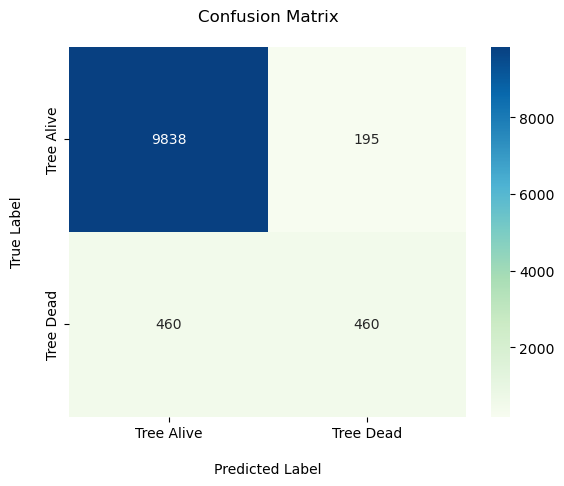

In [9]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
import seaborn as sns

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="GnBu",
    xticklabels=["Tree Alive", "Tree Dead"],
    yticklabels=["Tree Alive", "Tree Dead"],
)
plt.title("Confusion Matrix\n")
plt.ylabel("True Label\n")
plt.xlabel("\nPredicted Label")
plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

yr1status
0.0          33474
1.0           3035
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Tree Survival Status')

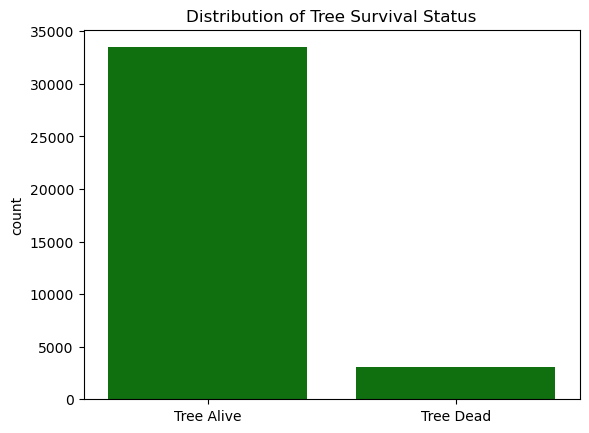

In [10]:
 # Count the values in each category
class_counts = y.value_counts().sort_index()
print(class_counts)

 # Create a barplot to visualize class imbalance in the dataset
sns.barplot(x=["Tree Alive", "Tree Dead"], y=class_counts, color='green')
plt.title("Distribution of Tree Survival Status")

The model performed slightly worse on the unseen data (Training Accuracy: 0.945 vs. Test Accuracy: 0.940). The model performs better on trees that survived, which makes sense because there is a class imbalance (there are much more trees that survived vs trees that died).

## Step 7: What about a Dummy?

What do you think would happen if we built a model that always predicts the majority class (alive trees)? How would its accuracy compare to your logistic regression model?

In [26]:
# Percentage of dead trees
print(f"Accuracy: {1-(class_counts[1]/(class_counts[0]+class_counts[1])):.3f}")

0.917


A model that always predicts the majority class would perform slightly worse than a logistic regression. It would have an accuracy of 0.92 vs 0.94 for the logistic regression. Its accuracy is high because there is extreme class imbalance in the data, but it would do poorly if there was a more equal distribution between classes.

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Accuracy: 0.917

Dummy Confusion Matrix: 
[[10033     0]
 [  920     0]]


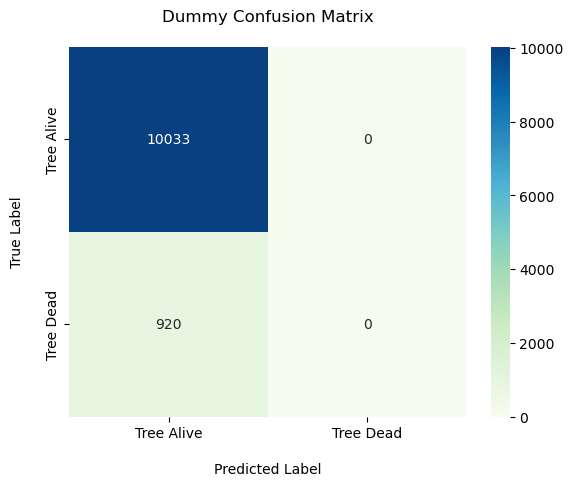

In [28]:
# Train dummy classifier
dummy_clf_model = DummyClassifier(strategy="most_frequent")
dummy_clf_model.fit(X_train_scaled, y_train)

# Make predictions
dummy_y_train_pred = dummy_clf_model.predict(X_train_scaled)
dummy_y_test_pred = dummy_clf_model.predict(X_test_scaled)

# Check score
dummy_train_score = accuracy_score(y_train, dummy_y_train_pred)

# Create confusion matrix
dummy_cm = confusion_matrix(y_test, dummy_y_test_pred)

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {dummy_train_score:.3f}")
print(f"\nDummy Confusion Matrix: \n{dummy_cm}")

sns.heatmap(
    dummy_cm,
    annot=True,
    fmt="d",
    cmap="GnBu",
    xticklabels=["Tree Alive", "Tree Dead"],
    yticklabels=["Tree Alive", "Tree Dead"],
)
plt.title("Dummy Confusion Matrix\n")
plt.ylabel("True Label\n")
plt.xlabel("\nPredicted Label")
plt.show()


# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [13]:
# Logistic classifier AUC
from sklearn.metrics import roc_curve, auc, confusion_matrix

y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
log_auc = auc(fpr, tpr)

print(f"Logistic AUC: {log_auc}")

Logistic AUC: 0.9180671176422154


In [14]:
# Dummy classifier AUC
fpr_dummy, tpr_dummy, _ = roc_curve(y_train, dummy_y_train_pred)
dummy_auc = auc(fpr_dummy, tpr_dummy)

print(f"Dummy AUC: {dummy_auc}")

Dummy AUC: 0.5


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

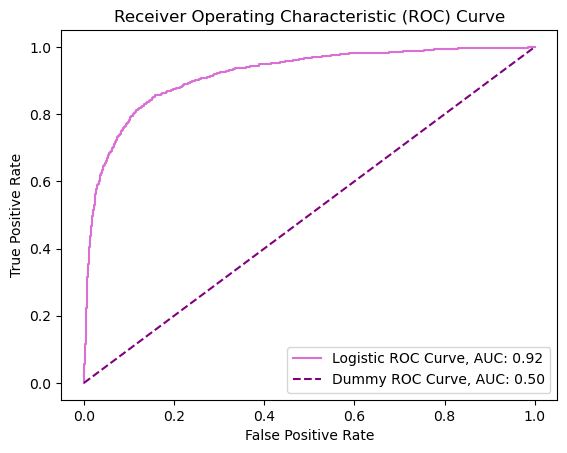

In [15]:
# Plot ROC curves
plt.figure()
plt.plot(fpr, tpr, label=(f"Logistic ROC Curve, AUC: {log_auc:.2f}"), color="orchid")
plt.plot(fpr_dummy, tpr_dummy, label=(F"Dummy ROC Curve, AUC: {dummy_auc:.2f}"), color="purple", linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

The dummy AUC is 0.5, which means that it is doing no better than guessing at distinguising between alive and dead trees. The logistic regression model has an AUC of 0.92. If we looked accuracy score alone to evalue the models, without knowing that the dummy classifier was predicting the majority class every time, then we would assume it was doing well on prediction. 

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [16]:
# Find model coefficients
coefficients = model.coef_[0]

# Create feature importance dataframe
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance (absolute value)': np.abs(coefficients)})
importance_df = importance_df.sort_values('Importance (absolute value)', ascending=False)
importance_df

# Print the sorted feature importance
print(importance_df)

             Feature  Importance (absolute value)
6            CR_post                     2.494974
4               HT_m                     1.165414
0     YrFireName_int                     0.660497
1        Species_int                     0.541509
3             DBH_cm                     0.421324
5             CR_pre                     0.123414
2  Genus_species_int                     0.067867
7       Times_burned                     0.000000


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

The most importance features in our model `CR_Post` (Post-fire live crown ratio; crown length divided by tree height) and `HT_m` (Pre-fire tree height). Forest management strategies could focus on preserving taller trees with large crowns, and clearing smaller trees for fire prevention. Knowing which characteristics of a tree make them more resilient to fire could inform decisions could help forest managers devote more resources to areas of trees lacking those characteristics to shore up fire prevention and conservation efforts. 